In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy
import importlib as il
import copy

In [24]:
import src.deh as deh
il.reload(deh)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from hypso.download import download_nc_files

In [ ]:
download_nc_files(filename_list=["griegnootka_2024-07-04_1909Z-l1a.nc"],
                  download_dir="D:/Downloads")

Processing *wide* Image with Dimensions: (598, 1092)
Radiometric Correction Ongoing
Smile Correction Ongoing
Destriping Correction Ongoing
L1b.nc file already exists. Not creating it.
Getting Projection Data without lat/lon correction =========================================
Generating Geotiff ************************************
  Projecting pixel geodetic to map ...
    [48.571518, 51.75434, -128.5628, -125.85475]
    using UTM map: WGS 84 / UTM zone 9N EPSG: 32609
    Area covered by image: 31849814754.41758 m^2 = 31849.81475441758 km^2
  Bounding boxes and resample grid ...
  Grid points inside bounding polygon ...
    Points inside boundary: 1273067 / 2627142
  Registration, aka rectification, aka resampling, aka gridding ...
      Starting band 11
      Starting band 61
      Starting band 50
      Starting band 31
      Done with band 61      Done with band 11
      Done with band 50

      Done with band 31
Done RGB/RGBA Geotiff
RGBA Tif File:  griegnootka_2024-07-04_1909Z-rgb

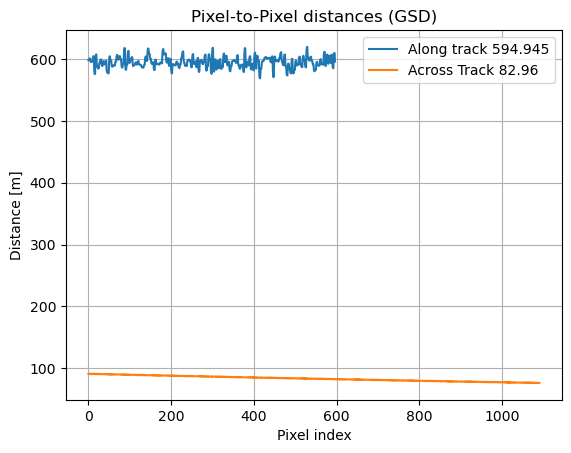

In [4]:
from hypso import Hypso #Hypso 1.9.9 version used

hypso_file_path="D:\Downloads\griegnootka_2024-07-04_1909Z-l1a.nc"
# load and calibrate the hypso image, e.g. convert to radiance
satobj = Hypso(hypso_file_path)

In [5]:
# block out any saturate pixels
maxes = np.max(satobj.rawcube, axis = -1) #rawcube is not an attribute of the Hypso object  
saturated = maxes > 35000

In [6]:
# use 'dark pixel subtraction' to remove the background, and remove noisy bands 
cube = satobj.get_toa_reflectance()[:,:,6:118]
c = cube.reshape(-1,112)
mins = [c[:,i].min() for i in range(112)]
cm = c - 0.95*np.array(mins)

In [7]:
dehe = deh.DEH(no_negative_residuals=True)

#the following are not used in the latest training version
dehe.splitting_size=1000
dehe.max_depth=2
dehe.max_iter=5
dehe.max_nodes=2

#these set the size of the image to be plotted
dehe.plot_size = (598,1092)
dehe.plot_aspect = 0.1

# these set the normaliztion on the data, but right now it is turned off and replaced with a nearest-neighbor noise estimate
dehe.weight_power=0
dehe.eps = 0.00
#dehe.wf = lambda x: (np.sum(x**2, axis=-1))**(-1/2+1/(2+dehe.eps))

#this switches between Archetype Analysis and Pure Pixel Analysis
dehe.aa = False

#this is currently replaced by "mpp_tol" in the training code
dehe.mixed_pix = 0

# this is the prefactor on the L2 regularization
dehe.reg=0

# if this is anything other than zero, it introduces L2 regularization on the trained weights 
dehe.set_mu(0)

# this turns on a sort of protection to keep endmembers from vanishing. Generally unneeded with new training
dehe.use_bonus_boost = False

# turns on normalization of the data. Generally always used
dehe.use_norm(True)

# if greater than 1, turns on a sort of spectral sampling with PAA. Occasionally gives good performance
# but I generally keep it at 1 to turn it off
dehe.PAA_backcount = 1

# changes the gradient descent learning rate as a proportion of the optimal rate. I recommend keeping it at 1
dehe.a_speed= 1.0

In [ ]:
# I think that I will stop changing the learning strategy, and will fill out the helptext with some of 
# the comments that I am leaving for you here, so this text will eventually be unnecessary

# This is the Sparsity Modulated Unmixing Growth method, but its currently split between a few functions
# for diagnostic purposes

# the first argument is the data, and the second argument is the number of endmembers to find

#'scales' is no longer used

# mpp_tol is the mixed pixel proportion tolerance. Endmembers splits are only selected below this level

# save, save_name - I think you can figure these out

# n_runs - the number of update steps for each stage in SMUG

# reg_max - the maximum value of the regularization lambda 


aorIV, anodes = dehe.adia_grow_network(cm, 6, scales=2, mpp_tol=0.2, save=True, n_update_pts=(1000,10000),
                  save_name='Nootka_test', n_runs=20, reg_max=0.1, saturation= saturated.flatten())
#164 min

In [9]:
# the SMUG training is split into two parts now
# in this second part, we trim the network
dehf = dehe.get_trimmed_network(anodes)

01
00
101
100
111
110


In [10]:
# The weights are re-defined as well, but this should be automated, and easy to automate
dehf.neighbors = deh.quick_nn(cm.reshape(dehf.plot_size + (-1,)), k_size=1).flatten()
dehf.set_neighbor_weights(cm)

In [11]:
# should be a default
dehf.PAA_backcount=1

In [ ]:
# now the trimmed network is stablized
dehf.accepted_network_stablization(cm, n_runs=20, n_pts=(1000,10000), obj_record=(), sampling_points=(),
                                 mpp_tol=0.2, step_delta=0.01, reg_max=0.2, name='experanza_test_2')
#70 min

In [13]:
dehx = deh.DEH(no_negative_residuals=True)

#the following are not used in the latest training version
dehx.splitting_size=1000
dehx.max_depth=2
dehx.max_iter=5
dehx.max_nodes=2

#these set the size of the image to be plotted
dehx.plot_size = (598,1092)
dehx.plot_aspect = 0.1

# these set the normaliztion on the data, but right now it is turned off and replaced with a nearest-neighbor noise estimate
dehx.weight_power=0
dehx.eps = 0.00
#dehx.wf = lambda x: (np.sum(x**2, axis=-1))**(-1/2+1/(2+dehx.eps))

#this switches between Archetype Analysis and Pure Pixel Analysis
dehx.aa = False

#this is currently replaced by "mpp_tol" in the training code
dehx.mixed_pix = 0

# this is the prefactor on the L2 regularization
dehx.reg=0

# if this is anything other than zero, it introduces L2 regularization on the trained weights 
dehx.set_mu(0)

# this turns on a sort of protection to keep endmembers from vanishing. Generally unneeded with new training
dehx.use_bonus_boost = False

# turns on normalization of the data. Generally always used
dehx.use_norm(True)

# if greater than 1, turns on a sort of spectral sampling with PAA. Occasionally gives good performance
# but I generally keep it at 1 to turn it off
dehx.PAA_backcount = 1

# changes the gradient descent learning rate as a proportion of the optimal rate. I recommend keeping it at 1
dehx.a_speed= 1.0

In [47]:
#alternatively we can use a random initialization

In [ ]:
dehx.neighbors = deh.quick_nn(cm.reshape(dehx.plot_size + (-1,)), k_size=1).flatten()
dehx.set_neighbor_weights(cm)
dehx.random_init(cm, 16)

In [31]:
dehx.simple_predict(cm)

array([[1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

2


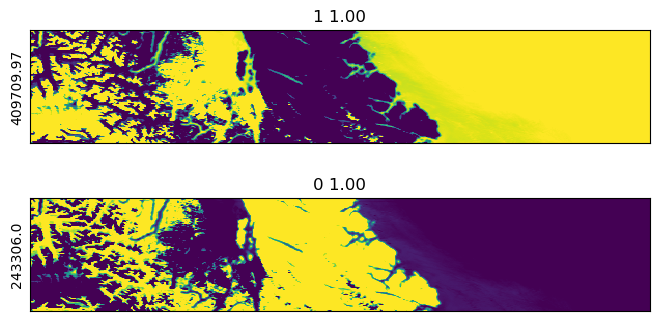

In [20]:
dehf.display_level(1)

4


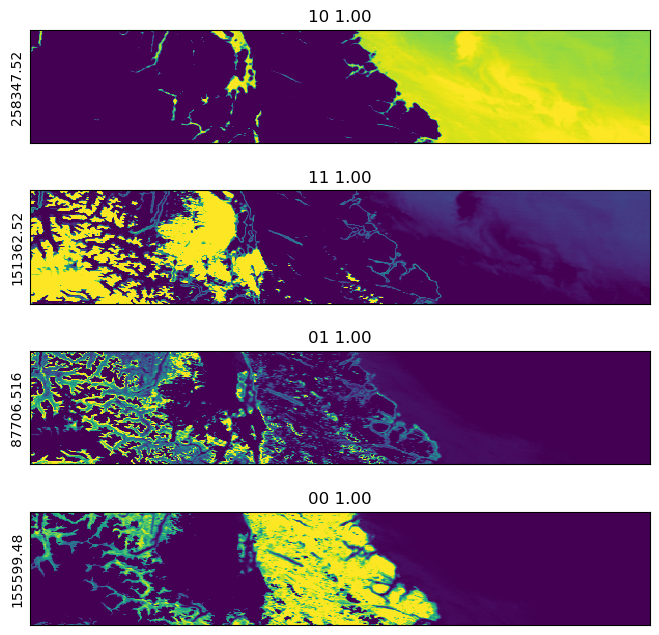

In [21]:
dehf.display_level(2)

6


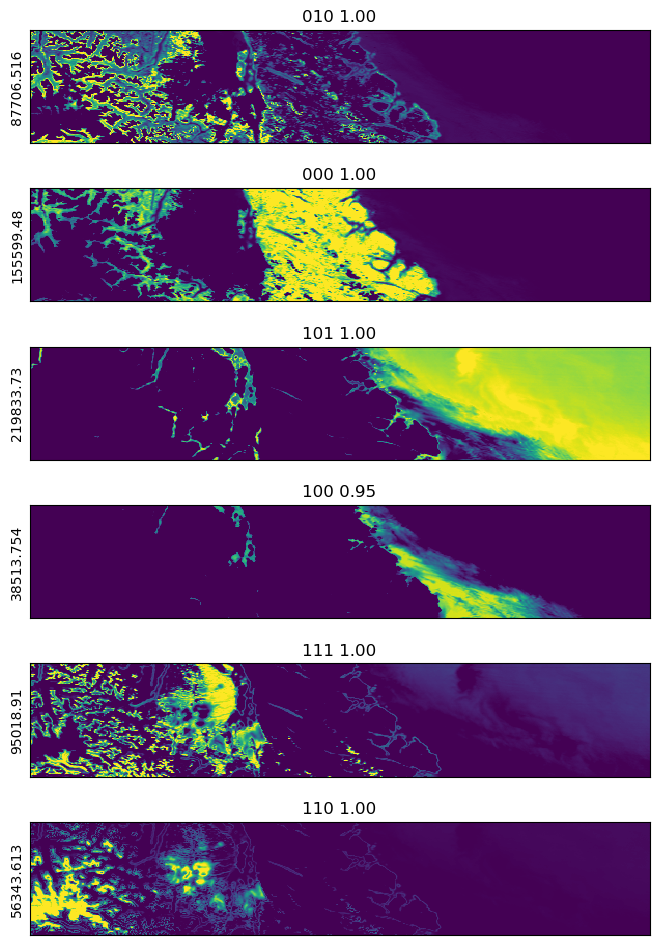

In [22]:
dehf.display_level(3)